In [1]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras import backend as K
import seaborn as sns
sns.set_style('white')
import os
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import base64
from PIL import Image
from numpy import array
import numpy as np
import random
from matplotlib import pyplot as plt
from skimage import data
%matplotlib inline
np.random.seed(seed=7)
import csv
import pandas as pd
from scipy import ndimage, misc
from skimage import io
from sklearn import preprocessing



Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Import in file paths for all the posters

In [2]:
#import in all of the movie genres and their corresponding movie ids
genre_map = pd.read_csv('/Users/aaronmyran/Dropbox/GRAD_SCHOOL/HKS/2ndyear/spring/CS109B/FinalProject/Milestone 3/genre_id_mapping.csv')
genre_map =genre_map.sort('ID')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [3]:
#get a list of all of the movie poster locations on my local disk
poster_list = os.listdir("/Users/aaronmyran/Dropbox/GRAD_SCHOOL/HKS/2ndyear/spring/CS109B/FinalProject/Posters")
poster_list = poster_list[1:-1]
root_dir = "/Users/aaronmyran/Dropbox/GRAD_SCHOOL/HKS/2ndyear/spring/CS109B/FinalProject/Posters/"

In [4]:

def convert_jpg_array(poster_name, root_dir = "/Users/aaronmyran/Dropbox/GRAD_SCHOOL/HKS/2ndyear/spring/CS109B/FinalProject/Posters/"):
    '''
    inputs: director of poster
    outputs: array of poster with shape 750,500,3
    '''
    poster_dir = root_dir + poster_name
    poster_id =  poster_name.split("-")[0]
    img = Image.open(poster_dir)
    img = misc.imresize(img, (750, 500))
    arr = array(img)
    return poster_id,arr 

def map_id_genre(genre_id,genre_map = genre_map):
    '''
    inputs: list of all the movies and their genres
    returns: the genre of the movie
    '''
    index = [i for i, x in enumerate(genre_map['ID']) if x==genre_id]
    try:
        output = genre_map.iloc[index[0],1]
    except IndexError:
        output = "Error"
    return output

def convert_jpg_array_grey(poster_name, root_dir = "/Users/aaronmyran/Dropbox/GRAD_SCHOOL/HKS/2ndyear/spring/CS109B/FinalProject/Posters/"):
    '''
    inputs: director of poster
    outputs: array of poster with shape 750,500,1 **Greyscale**
    '''
    poster_dir = root_dir + poster_name
    poster_id =  poster_name.split("-")[0]
    img = img = io.imread(poster_dir, as_grey=True)
    img = misc.imresize(img, (750, 500))
    arr = array(img)
    return poster_id,arr 


test wit small list

(750, 500)

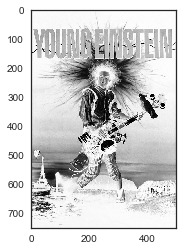

In [5]:
a = convert_jpg_array_grey(poster_list[3])
plt.imshow(a[1])
a[1].shape

In [6]:
#CNN deets
img_rows = 750
img_cols = 500
epochs = 10
batch_size= 512
num_classes = 10
input_shape = (1,img_rows,img_cols)


In [8]:
#small list to see if it will work in keras
train_movies = np.random.choice(poster_list, 5000)
test_movies = np.random.choice(poster_list, 1000)

In [ ]:

#append all the movies into 1 numpy frame for training data
train_movie_arrays = []
train_movie_id = []
train_movie_genre = []
for m in train_movies:
    m_id, arr = convert_jpg_array_grey(m)
    train_movie_id.append(int(m_id))
    train_movie_arrays.append(arr)
    train_movie_genre.append(map_id_genre(int(m_id)))
#append all the movie genres into a list
train_movie_pixels = np.dstack((train_movie_arrays))
x_train = train_movie_pixels.reshape(train_movie_pixels.shape[2],img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)

####***testing data too***
test_movie_arrays = []
test_movie_id = []
test_movie_genre = []
for m in test_movies:
    m_id, arr = convert_jpg_array_grey(m)
    test_movie_id.append(int(m_id))
    test_movie_arrays.append(arr)
    test_movie_genre.append(map_id_genre(int(m_id)))
#append all the movie genres into a list
test_movie_pixels = np.dstack((test_movie_arrays))
x_test = test_movie_pixels.reshape(test_movie_pixels.shape[2],img_rows, img_cols, 1)
print('x_test shape:', x_test.shape)

In [384]:
num_classes = len(np.unique([test_movie_genre+train_movie_genre]))
le = preprocessing.LabelEncoder()
le.fit(np.unique([test_movie_genre+train_movie_genre]))
y_test = le.transform(test_movie_genre)
y_train = le.transform(train_movie_genre)

In [385]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
###save numpy files so I don't have to run previous stuff
np.save('x_train', x_train)
np.save('y_train', y_train)
np.save('y_train', y_train)
np.save('y_test', y_test)

In [392]:
# create an empty network model
model = Sequential()

# --- input layer ---
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(img_rows,img_cols, 1)))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# --- classification ---
model.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 746, 496, 16)      416       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 373, 248, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 371, 246, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 185, 123, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 728160)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                46602304  
_________________________________________________________________
dense_9 (Dense)              (None, 12)                780       
Total para

In [393]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 100 samples, validate on 100 samples
Epoch 1/10


In [389]:
y_test[1].shape

(12,)